# Práctica 5 

### Ejercicio 1
La base de datos MNIST contiene imágenes de 28×28, en escala de grises, de números escritos a mano.
Está conformada por 60.000 ejemplos de entrenamiento y 10.000 ejemplos de prueba. 

a) Con el conjunto de 60000 imágenes entrene una red neuronal convolucional para predecir el dígito
presente en la imagen. Recuerde normalizar los valores de cada imagen. Salve el modelo para
recuperarlo después.

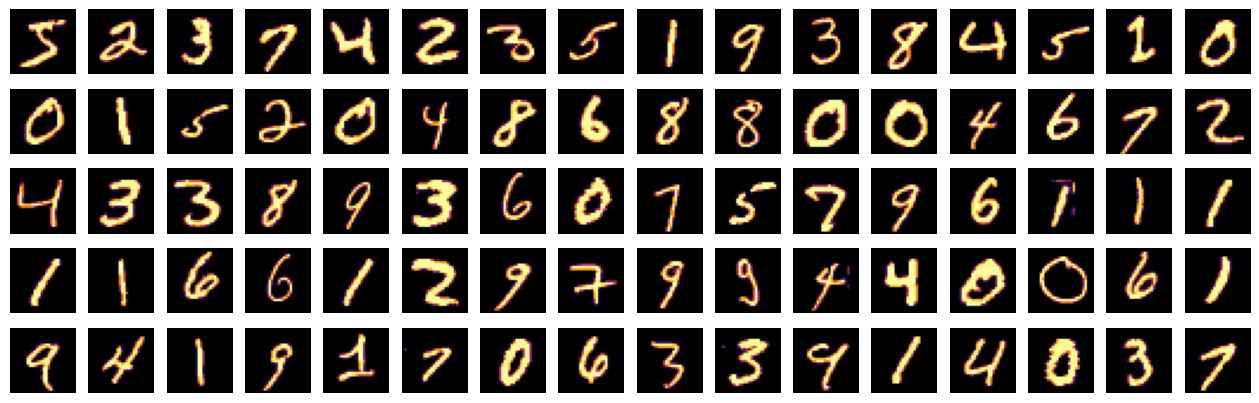

In [11]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
import tensorflow as tf
from sklearn import metrics
import seaborn as sns

import  matplotlib.pyplot as plt
import numpy as np

# %% Carga y perparación de datos de entrenamiento y testeo

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Y_train= to_categorical(np.array(Y_train))
Y_test = to_categorical(np.array(Y_test))

# dimension de las imagenes sacadas del primer ejmeplo
IMG_SHAPE = X_train[0].shape # (28,28)
TARGET_CNT= len(Y_train[0])  # 10 dígitos/clases

# normalización
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


# Crear una figura para mostrar las imágenes en una matriz de FILAS x COLS
COLOR_MAP = 'inferno'  #@param ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'gray']
FILAS = 5          #@param {type:"slider", min:3, max:6, step:2}
COLS = 16               #@param {type:"slider", min:10, max:20, step:2}
fig, axes = plt.subplots(FILAS, COLS, figsize=(COLS, FILAS))

# Iterar sobre cada imagen a visualizar
for i in range(COLS):
    for j in range(FILAS):
        # Seleccionar la imagen correspondiente
        img = X_train[i * FILAS + j]
        # Mostrar la imagen en la posición correspondiente de la matriz
        axes[j, i].imshow(img, cmap=COLOR_MAP)
        axes[j, i].axis('off')  # Ocultar los ejes

In [12]:
# ----------------------------------------------------------
# Definición de parámetros base
# ----------------------------------------------------------
PADDING = 'same'   # Mantiene el tamaño original de la imagen en las convoluciones
ACTIV = 'relu'     # Función de activación ReLU (f(x) = max(0, x))

# ----------------------------------------------------------
# Creación del modelo secuencial
# ----------------------------------------------------------
from tensorflow.keras import Sequential, Input, optimizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()  # Modelo secuencial: las capas se apilan una sobre otra

# ----------------------------------------------------------
# Capa de entrada
# ----------------------------------------------------------
# Define el tamaño de las imágenes de entrada (28x28x1 → escala de grises)
model.add(Input(shape=(*IMG_SHAPE, 1)))  # (*IMG_SHAPE, 1) = (28, 28, 1)

# ----------------------------------------------------------
# 1° Bloque Convolucional
# ----------------------------------------------------------
model.add(Conv2D(
    32,                     # cantidad de filtros
    kernel_size=(3,3),      # tamaño del filtro 3x3
    strides=(1,1),          # paso del filtro (1 pixel por vez)
    activation=ACTIV,       # función de activación ReLU
    padding=PADDING         # conserva el tamaño original ('same')
))
model.add(MaxPooling2D(pool_size=(2,2)))  # reduce a la mitad el tamaño (28x28 → 14x14)

# ----------------------------------------------------------
# 2° Bloque Convolucional
# ----------------------------------------------------------
model.add(Conv2D(
    64,                     # más filtros → detecta patrones más complejos
    kernel_size=(3,3),
    strides=(1,1),
    activation=ACTIV,
    padding=PADDING
))
model.add(MaxPooling2D(pool_size=(2,2)))  # reduce tamaño (14x14 → 7x7)

# ----------------------------------------------------------
# 3° Bloque Convolucional
# ----------------------------------------------------------
model.add(Conv2D(
    128,                    # aún más filtros → aprende combinaciones más abstractas
    kernel_size=(3,3),
    strides=(1,1),
    activation=ACTIV,
    padding=PADDING
))
model.add(MaxPooling2D(pool_size=(2,2)))  # reduce tamaño (7x7 → 3x3)

# ----------------------------------------------------------
# Aplanar la salida para conectarla con las capas densas
# ----------------------------------------------------------
model.add(Flatten())  # Convierte la salida 3D (alto, ancho, canales) en un vector 1D

# ----------------------------------------------------------
# Capa densa intermedia (oculta)
# ----------------------------------------------------------
model.add(Dense(
    64,             # 64 neuronas completamente conectadas
    activation=ACTIV
))

# ----------------------------------------------------------
# Capa de salida
# ----------------------------------------------------------
model.add(Dense(
    TARGET_CNT,     # cantidad de clases (para MNIST = 10)
    activation='softmax'  # convierte la salida en probabilidades (suman 1)
))

# ----------------------------------------------------------
# Compilación del modelo
# ----------------------------------------------------------
optimizer = optimizers.Adam(learning_rate=0.0001)  # optimizador Adam con LR bajo

model.compile(
    optimizer=optimizer,                # método para ajustar los pesos
    loss='categorical_crossentropy',    # función de pérdida para clasificación multiclase
    metrics=['accuracy']                # métrica a mostrar durante entrenamiento
)

# ----------------------------------------------------------
# Mostrar resumen de la arquitectura del modelo
# ----------------------------------------------------------
model.summary()  # imprime las capas, formas de salida y cantidad de parámetros


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,114 (652.79 KB)

 Trainable params: 167,114 (652.79 KB)

 Non-trainable params: 0 (0.00 B)

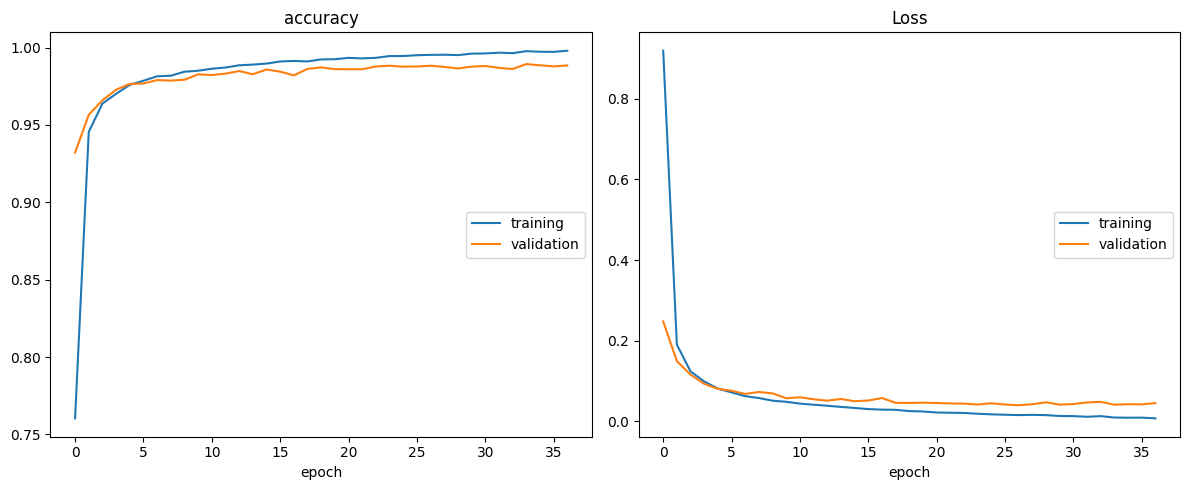

In [13]:
from livelossplot import PlotLossesKeras
from livelossplot.outputs import MatplotlibPlot

LOTES  = 128
EPOCAS = 100
PACIENCIA = 10

# parada temprana para evitar el sobreajuste
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA, restore_best_weights=True )
visual_plot = PlotLossesKeras( outputs=[ MatplotlibPlot(figsize=(12, 5)) ] )

# %% Entrenamiento del modelo usando datos de entrenamiento y validacion
H = model.fit(x=X_train, y=Y_train, batch_size=LOTES,
              epochs=EPOCAS,
              validation_split=0.3,
              callbacks=[early_stop, visual_plot],
              verbose=0
              )

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


<Axes: >

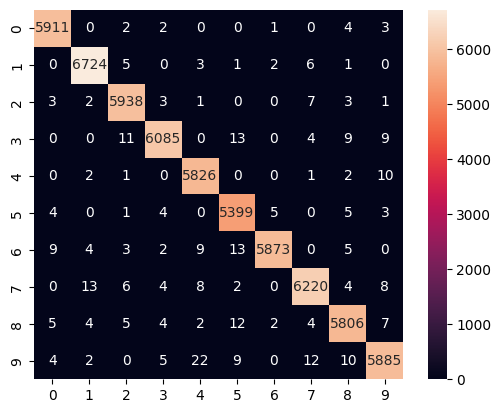

In [14]:
pred = model.predict(X_train)
cm = metrics.confusion_matrix(np.argmax(Y_train, axis=1), np.argmax(pred, axis=1))
plt.figure()
sns.heatmap(cm, square=True,  annot=True, fmt='d')

In [16]:
# %% evalua el modelo para entrenamiento y testeo
pred = model.evaluate(X_train, Y_train, verbose=0)
print("\nEfectividad del modelo con datos de entrenamiento: %6.2f%%" % (pred[1]*100))

# evalua el modelo con los datos de validacion
pred = model.evaluate(X_test, Y_test, verbose=0)
print("Efectividad del modelo con datos de Prueba.......: %6.2f%%" % (pred[1]*100))

model.save('my_model.keras')


Efectividad del modelo con datos de entrenamiento:  99.44%
Efectividad del modelo con datos de Prueba.......:  99.00%


b) Levante el modelo guardado en el punto a) y utilice la clase DrawPanel del módulo utils.images de
la carpeta fuentes para generar un dibujo escrito a mano de un dígito y predecir la clase a la que
pertenece

In [3]:
from tensorflow.keras.models import load_model

model = load_model('my_model.keras')

import pygame
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

# Inicializar pygame
pygame.init()

# Dimensiones del panel de dibujo (ajustado para 200x200 píxeles)
WIDTH, HEIGHT = 200, 200
WHITE = (255, 255, 255)
BLACK = (0, 0, 0)

# Crear la pantalla
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("Dibuja un dígito")

# Llenar la pantalla de blanco
screen.fill(WHITE)

# Variable para salir del bucle
drawing = False

def draw_circle(screen, x, y):
    pygame.draw.circle(screen, BLACK, (x, y), 10)

# Bucle principal de pygame
running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        # Iniciar el dibujo al hacer clic
        if event.type == pygame.MOUSEBUTTONDOWN:
            drawing = True

        # Detener el dibujo al soltar el botón
        if event.type == pygame.MOUSEBUTTONUP:
            drawing = False

        # Dibujar mientras el mouse se mueve y el botón está presionado
        if event.type == pygame.MOUSEMOTION and drawing:
            x, y = event.pos
            draw_circle(screen, x, y)

    pygame.display.update()

# Guardar la imagen dibujada
pygame.image.save(screen, "digit.png")

# Cerrar pygame
pygame.quit()


In [5]:
# Cargar la imagen y redimensionarla a 28x28 para el modelo
img = Image.open("digit.png").convert('L')  # Convertir a escala de grises
img = img.resize((28, 28))  # Redimensionar a 28x28
img_array = np.array(img)

# Invertir los colores (si lo dibujas en negro sobre fondo blanco)
img_array = 255 - img_array

# Normalizar la imagen
img_array = img_array / 255.0

# Redimensionar la imagen para que tenga la forma correcta (1, 28, 28, 1)
img_array = img_array.reshape(1, 28, 28, 1)

# Cargar el modelo de TensorFlow
model = load_model('my_model.keras')

# Hacer la predicción
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)

print(f"El dígito predicho es: {predicted_class[0]}") 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
El dígito predicho es: 3


### Ejercicio 2
Se buscará resolver la clasificación de los dígitos de MNIST usando la siguiente configuración:  
model = Sequential()  
model.add(Input(shape=(28, 28, 1)))  
model.add(Conv2D(F, kernel_size=K, strides=(S,S), activation=FUN)) 
model.add(MaxPooling2D(pool_size=(2,2)))   # -- opcional -- 
model.add(Flatten()) 
model.add(Dense(10,activation='softmax'))  
model.summary()  

donde F es la cantidad de filtros o de mapas de características, K es el tamaño del kernel o máscara, S es el 
valor del stride y FUN es la función de activación de la capa de convolución. 

La tabla que aparece a continuación sugiere los valores a utilizar. Se recomienda emplear Parada 
Temprana para reducir el tiempo de entrenamiento. Para ello utilice

from tensorflow.keras.callbacks import EarlyStopping  
es = EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)

Esto indica que, si el valor del accuracy sobre los datos de validación no mejora después de 5 épocas, el 
entrenamiento finaliza. Puede usarse el parámetro min_delta para indicar cuando la diferencia entre dos 
accuracy se considerará significativa.  Luego agregue este objeto en el momento del entrenamiento por 
medio del párametro callbacks  

H = model.fit(x = X_train, y = Y_train, batch_size = LOTES,                 
validation_data = (X_test, Y_test), epochs=4000, callbacks=[es]) 

In [21]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn import metrics
import seaborn as sns

import  matplotlib.pyplot as plt
import numpy as np

(X_train, Y_train), (X_test, Y_test) = mnist.load_data() #cargo el dataset de tensorflow

Y_train= to_categorical(np.array(Y_train))
Y_test = to_categorical(np.array(Y_test))

# normalización
X_train = X_train / 255
X_test  = X_test  / 255

FUN= 'sigmoid'
F= 64
K= (3, 3)
STRIDE= 1
LOTES= 32

model = Sequential()  
model.add(Input(shape=(28, 28, 1)))  
model.add(Conv2D(F, kernel_size=K, strides=(STRIDE,STRIDE), activation=FUN)) 
model.add(MaxPooling2D(pool_size=(2,2)))    
model.add(Flatten()) 
model.add(Dense(10,activation='softmax'))  
model.summary()  

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)

H = model.fit(x = X_train, y = Y_train, batch_size = LOTES,                 
validation_data = (X_test, Y_test), epochs=4000, callbacks=[es])

pred = model.predict(X_train)

#total de parámetros
total_params = model.count_params()
print(f'Total de parámetros del modelo: {total_params}')

# epocas
epochs_run = len(H.history['loss'])
print(f'Número de épocas ejecutadas: {epochs_run}')

# accuracy train
pred = model.evaluate(X_train, Y_train, verbose=0)
print("\n(ACCURACY) Efectividad del modelo con datos de entrenamiento: %6.2f%%" % (pred[1]*100))

# accuracy test
pred = model.evaluate(X_test, Y_test, verbose=0)
print("\n(ACCURACY) Efectividad del modelo con datos de prueba: %6.2f%%" % (pred[1]*100))

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │       108,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,810 (425.04 KB)

 Trainable params: 108,810 (425.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4000
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7542 - loss: 0.8107 - val_accuracy: 0.8824 - val_loss: 0.4040
Epoch 2/4000
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8830 - loss: 0.4140 - val_accuracy: 0.9170 - val_loss: 0.2987
Epoch 3/4000
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9107 - loss: 0.3150 - val_accuracy: 0.9365 - val_loss: 0.2143
Epoch 4/4000
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9345 - loss: 0.2267 - val_accuracy: 0.9506 - val_loss: 0.1727
Epoch 5/4000
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9515 - loss: 0.1650 - val_accuracy: 0.9510 - val_loss: 0.1638
Epoch 6/4000
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9615 - loss: 0.1310 - val_accuracy: 0.9671 - val_loss: 0.1053
Epoch 7/4000
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9658 - loss: 0.1163 - val_accuracy: 0.9553 - val_loss: 0.1430
Epoch 8/4000
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9710 -

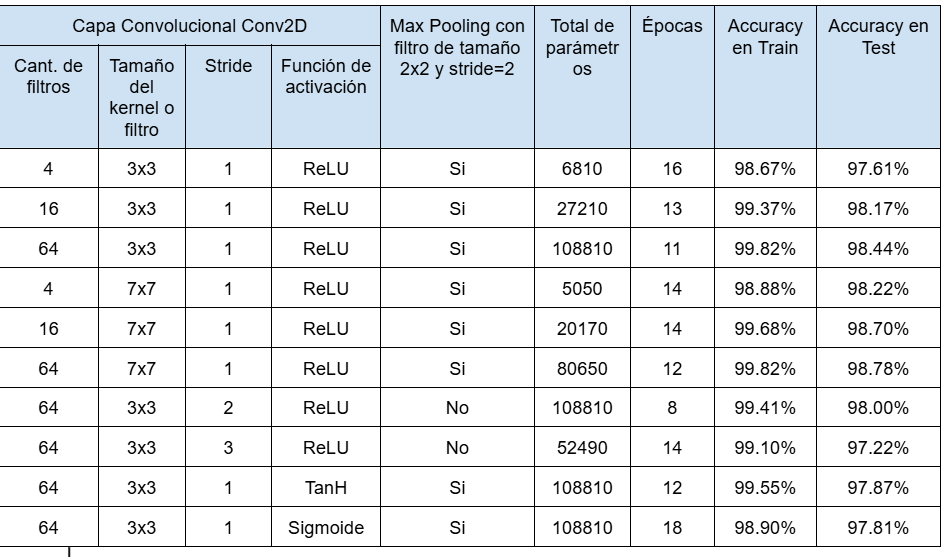

#### Mis interpretaciones
Efecto cantidad de filtros: Más filtros permiten extraer más patrones (bordes, texturas, curvas, etc.), mejorando la capacidad de generalización. Pero Aumentan los parámetros del modelo (de 6 810 a 108 810), lo que incrementa el costo computacional.

Tamaño del kernel: 3x3 Excelente balance entre detalle y eficiencia. 7x7 Similar resultado, pero con más parámetros y mayor tiempo de entrenamiento (porque el kernel es más grande).

Efecto stride: stride > 1 acelera el modelo a costa de perder algo de detalle.

Maxpooling: el pooling ayuda a evitar sobreajuste y a resumir mejor la información espacial.

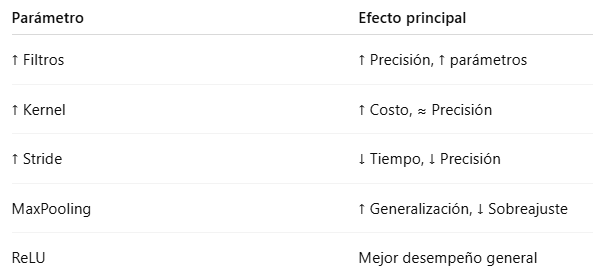

### Ejercicio 3
Para resolver este ejercicio utilice un modelo de red neuronal convolucional que reconozca la cantidad de 
dedos extendidos en cada mano de las imágenes que conforman el juego de datos “Fingers”. 

a) Entrene y pruebe un modelo utilizando los datos de las carpetas test y train, midiendo accuracy 

b) Genere una versión del dataset para test agregando transformaciones al azar sobres imágenes 
originales. Haga rotaciones entre -45 y 45 grados, repita el test y mida el accuracy. 

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

IMG_ERROR = 'No hay imágenes para cargar. Verificar que la ruta sea correcta y que la carpeta tenga imagenes con la extensión usada'


def import_data(data_dir):

    img_list = glob.glob(data_dir)      # Obtener la lista de archivos de imágenes

    assert len(img_list) > 0, IMG_ERROR # verifica que la ruta sea correcta y tenga al menos 1 imagen

    img_data = []  # lista de imagenes
    lbl_data = []  # lista de etiquetas

    img_count = len(img_list)
    for i, img_path in enumerate(img_list):

        img = Image.open(img_path)          # Carga imagen
        img = np.array(img) / np.max(img)   # Normaliza los píxeles entre 0 y 1
        img = img.reshape((*img.shape, 1))  # Formatea la imagen para TF: WxH => WxHx1

        # Almacenar la imagen y la etiqueta
        img_data.append(img)
        # ej. nombre de archivo: 000e7aa6-100b-4c6b-9ff0-e7a8e53e4465_5L.png
        lbl_data.append(int(img_path[-6]))  # Extrae la cantidad de dedos del nombre del archivo

        # Mostrar progreso en la carga
        if i % 100 == 0:
            print("\rCargando imágenes: %6.2f%%" % (100 * i / img_count), end="")

    print("\rCargando imágenes: 100.00%% (%d) \n" % img_count)

    return np.array(img_data), np.array(lbl_data)


# carga las imagenes a partir de los nombres de archivos
x_train, y_train = import_data('./Fingers/train/*/*.png')

# carga las imagenes a partir de los nombres de archivos
x_test, y_test = import_data('./Fingers/test/*/*.png')

# separa los datos y clase en grupo de entrenamiento y validacion
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.30, shuffle = True)

Cargando imágenes: 100.00% (17999) 

Cargando imágenes: 100.00% (3600) 



In [5]:
# clases (0..5) por ejemplo
display(y_train)
# cantidad de ejemplos por clase (0..5)
display(np.bincount(y_train))

array([0, 4, 4, ..., 5, 1, 1], shape=(12599,))

array([2097, 2089, 2081, 2105, 2119, 2108])

In [6]:
EPOCAS = 100
LOTES  = 128
PACIENCIA=5
IMG_SIZE = x_train.shape[1:]
N_CLASSES = len(np.unique(y_train))
ACTIVA =LeakyReLU()

# Construye el modelo
model = Sequential()

model.add(Input( shape=IMG_SIZE ))
model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same', activation=ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation=ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(32, activation = ACTIVA))
model.add(Dense(N_CLASSES, activation = 'softmax'))

model.summary()

# construye el modelo
optimizer = optimizers.Adam(0.001)
# Observar que con "sparse_categorical_crossentropy" no hace falta codificacion one-hot para las clases
model.compile(optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


# parada temprana para evitar el sobreajuste
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA, min_delta=0.001, restore_best_weights=True )

# entrena el modelo y guarda la historia del progreso
H = model.fit(x_train,
              y_train,
              batch_size = LOTES,
              epochs = EPOCAS,
              validation_data = (x_val, y_val),
              callbacks=[early_stop]
             )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │       262,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,174 (1.02 MB)

 Trainable params: 267,174 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8952 - loss: 0.3542 - val_accuracy: 0.9885 - val_loss: 0.0396
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9930 - loss: 0.0267 - val_accuracy: 0.9981 - val_loss: 0.0097
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9989 - loss: 0.0069 - val_accuracy: 1.0000 - val_loss: 0.0049
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9997 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9998 - val_loss: 0.0018
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 1.0000 - loss: 7.8711e-04 - val_accuracy: 1.0000 - val_loss: 5.8320e-04
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 1.0000 - loss: 4.4207e-04 - val_accuracy: 1.0000 - val_loss: 4.7046e-04
Epoch 8/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 1.0000 - loss: 3.4831e-0

### Ejercicio 4
Resuelva el punto c) del ejercicio anterior con las imágenes originales de las carpetas train y test y utilice:

a) el objeto ImageDataGenerator del módulo tensorflow.keras.preprocessing.image para generar 
de forma automática una versión aumentada de los datos con  las características del punto b). 
Utilice el método flow_from_file del objeto ImageDataGenerator para utilizar directamente las 
imágenes de las carpetas en vez de cargarlas en memoria. 

b) repita el punto a) utilizando la función tf.keras.utils.image_dataset_from_directory para generar 
el dataset a partir de carpetas en combinación con funciones para aplicar el preprocesamiento/data 
augmentation. 

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, InputLayer, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = (64, 64, 1)
N_CLASSES = 6
LOTES  = 64

data_train_generator = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=60,         # rotacion
    rescale=1./255,            # escalado [0,1]
    # zoom_range=0.15,         # zoom
    # width_shift_range=0.1,   # desplazamiento horizontal
    # height_shift_range=0.1,  # desplazamiento vertical
    # shear_range=0.15,        #
    # horizontal_flip=False,   # espejo horizontal
    #vertical_flip=False,      # espejo vertical
    fill_mode="reflect"
    )

# generador para entrenamiento a partir de la carpeta indicada
train_iter = data_train_generator.flow_from_directory(
            target_size=(IMG_SIZE[0],IMG_SIZE[1]),
            directory='./Fingers/train/', # carpeta de datos
            class_mode='categorical',            # utiliza codificacion one-hot
            batch_size=LOTES,                    # Tamaño del lote
            color_mode='grayscale',              # aplica transformación
            subset='training'                    # asigna subconjunto por validation_split del ImageDataGenerator
            )

valid_iter = data_train_generator.flow_from_directory(
            target_size=(IMG_SIZE[0],IMG_SIZE[1]),
            directory='./Fingers/train/', # carpeta de datos
            class_mode='categorical',            # utiliza codificacion one-hot
            batch_size=LOTES,                    # Tamaño del lote
            color_mode='grayscale',              # aplica transformación
            subset='validation'                  # asigna subconjunto por validation_split del ImageDataGenerator
            )


data_test_generator = ImageDataGenerator(
    rotation_range=60,         # rotacion
    rescale=1./255,            # escalado [0,1]
    # zoom_range=0.15,         # zoom
    # width_shift_range=0.1,   # desplazamiento horizontal
    # height_shift_range=0.1,  # desplazamiento vertical
    # shear_range=0.15,        #
    # horizontal_flip=False,   # espejo horizontal
    #vertical_flip=False,      # espejo vertical
    fill_mode="reflect"
    )

test_iter = data_test_generator.flow_from_directory(
            target_size=(IMG_SIZE[0],IMG_SIZE[1]),
            directory='./Fingers/test/',     # carpeta de datos
            class_mode='categorical',               # utiliza codificacion one-hot
            color_mode='grayscale',                 # aplica transformación
            batch_size=LOTES                        # Tamaño del lote
            )

Found 14400 images belonging to 6 classes.
Found 3600 images belonging to 6 classes.
Found 3600 images belonging to 6 classes.


In [11]:
EPOCAS = 50
LOTES  = 128
PACIENCIA=4

FN_ACTIVA = LeakyReLU()

# Construye el modelo
model = Sequential()

model.add(Input(shape=IMG_SIZE))
model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(FN_ACTIVA)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation=FN_ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation = FN_ACTIVA))
model.add(Dense(N_CLASSES, activation = 'softmax'))

model.summary()

# construye el modelo
optimizer = 'Adam' #optimizers.Adam(0.001)
model.compile(optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])


# parada temprana para evitar el sobreajuste
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA, restore_best_weights=True)

H = model.fit(
    train_iter,
    validation_data=valid_iter,
    epochs=EPOCAS,
    callbacks=[early_stop],
    verbose=1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 529,542 (2.02 MB)

 Trainable params: 529,542 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


c:\Users\milen\Documents\Facultad\DeepLearning\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.8119 - loss: 0.5291 - val_accuracy: 0.9783 - val_loss: 0.0967
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9812 - loss: 0.0655 - val_accuracy: 0.9883 - val_loss: 0.0379
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9911 - loss: 0.0308 - val_accuracy: 0.9958 - val_loss: 0.0160
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9979 - loss: 0.0111 - val_accuracy: 0.9997 - val_loss: 0.0058
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.9990 - loss: 0.0059 - val_accuracy: 0.9989 - val_loss: 0.0043
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9978 - loss: 0.0079 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9976 - loss: 0.0080 - val_accuracy: 0.9997 - val_loss: 0.0016
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9980 - loss: 0.0067 - val_accurac

Efectividad del modelo con datos de Prueba rotado   0 grados: 100.00%
Efectividad del modelo con datos de Prueba rotado   5 grados: 100.00%
Efectividad del modelo con datos de Prueba rotado  10 grados:  98.44%
Efectividad del modelo con datos de Prueba rotado  15 grados:  98.44%
Efectividad del modelo con datos de Prueba rotado  20 grados:  98.44%
Efectividad del modelo con datos de Prueba rotado  25 grados:  95.31%
Efectividad del modelo con datos de Prueba rotado  30 grados:  93.75%
Efectividad del modelo con datos de Prueba rotado  35 grados:  93.75%
Efectividad del modelo con datos de Prueba rotado  40 grados:  92.19%
Efectividad del modelo con datos de Prueba rotado  45 grados:  87.50%
Efectividad del modelo con datos de Prueba rotado  50 grados:  84.38%
Efectividad del modelo con datos de Prueba rotado  55 grados:  81.25%
Efectividad del modelo con datos de Prueba rotado  60 grados:  81.25%
Efectividad del modelo con datos de Prueba rotado  65 grados:  79.69%
Efectividad del mode

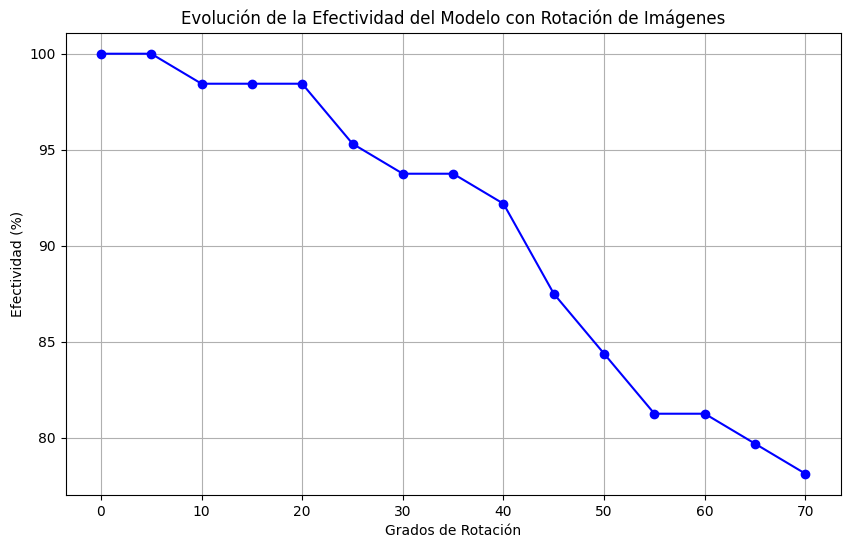

In [13]:
from skimage.transform import rotate

def rotar_grados(data_imgs, ang):
    result = np.empty_like(data_imgs)
    for i, img in enumerate(data_imgs):
        result[i] = rotate(img, ang, resize=False, mode='reflect')
    return result

batch_images, batch_labels = next(test_iter)

# Lista para almacenar los resultados de la efectividad
efectividades = []
grados_rotacion = []

for i in range(15):
    grados = i * 5
    x_test_rot = rotar_grados(batch_images, grados)

    # Evalúa el modelo con los datos de prueba rotados
    pred = model.evaluate(x_test_rot, batch_labels, verbose=0)
    efectividad = pred[1] * 100
    print("Efectividad del modelo con datos de Prueba rotado %3d grados: %6.2f%%" % (grados, efectividad))

    # Almacena los resultados
    efectividades.append(efectividad)
    grados_rotacion.append(grados)

# Crea el gráfico
plt.figure(figsize=(10, 6))
plt.plot(grados_rotacion, efectividades, marker='o', linestyle='-', color='b')
plt.title('Evolución de la Efectividad del Modelo con Rotación de Imágenes')
plt.xlabel('Grados de Rotación')
plt.ylabel('Efectividad (%)')
plt.grid(True)
plt.show()

### Ejercicio 5
“Flowers” es un juego de datos compuesto por 16 categorías de flores con unas 1000 imágenes de RGB de 
256 x 256 píxeles disponible en Kaggle en el enlace https://www.kaggle.com/datasets/l3llff/flowers. 
En la carpeta de datos del Moodle del curso hay una versión reducida de 96 x 96 píxeles. Utilice este dataset para entrenar varios modelos de redes convolucionales que permitan clasificar las 16 flores según las especificaciones que siguen a continuación.  

Para cada modelo a entrenar contabilice la cantidad de épocas, accuracy y tiempo promedio por época 
(utilice la clase EpochTiming definida en el paquete tf_utils de la carpeta Fuentes como callback para el 
entrenamiento). Utilice 250 épocas para los entrenamientos y agregue una parada temprana para evitar 
overfitting. 

a) Entrene un modelo que utilice solamente capas Conv2D, MaxPooling2D, Flatten y Dense. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, LeakyReLU, Activation, BatchNormalization
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import unidecode
from tf_util import EpochTiming

# Constantes para arquitectura, generación de datos y entrenamiento/validación
IMG_SIZE = (96, 96)  # Tamaño de la imagen de entrada (se elimina el canal de la tupla)
N_CLASSES = 16       # Cantidad de clases a identificar
LOTES = 256          # Tamaño de lotes para entrenamiento y testeo
ALFA = 0.0005        # Tasa de aprendizaje
EPOCAS = 100         # Cantidad de épocas a entrenar como máximo
PACIENCIA = 10       # Parámetro para parada temprana
VAL_SPLIT = 0.2      # Porcentaje para validación

IMAGES_DIR = './FlowersX16/'  # Directorio con las imágenes organizadas en subcarpetas por clase

for root, dirs, files in os.walk(IMAGES_DIR):
    for name in dirs + files:
        new_name = unidecode.unidecode(name).replace(" ", "_")
        old_path = os.path.join(root, name)
        new_path = os.path.join(root, new_name)
        if old_path != new_path:
            os.rename(old_path, new_path)
            print(f"Renombrado: {old_path} → {new_path}")

# Función para crear datasets con aumento de datos
def create_dataset(directory, subset=None, shuffle=True):
    # Cargar dataset desde directorio
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=VAL_SPLIT,
        subset=subset,
        seed=123,
        image_size=IMG_SIZE,
        batch_size=LOTES,
        shuffle=shuffle
    )

    # Normalización
    def preprocess(image, label):
        return image/255.0, label

    # Aumento de datos (solo para entrenamiento)
    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)

        # Zoom y desplazamiento
        if tf.random.uniform(()) > 0.5:
            image = tf.image.central_crop(image, 0.85)
            image = tf.image.resize(image, IMG_SIZE)

        return image, label

    dataset = dataset.map(preprocess)
    if subset == 'training':
        dataset = dataset.map(augment)

    return dataset.cache().prefetch(tf.data.AUTOTUNE)

# Crear datasets
train_ds = create_dataset(IMAGES_DIR, subset='training', shuffle=True)
valid_ds = create_dataset(IMAGES_DIR, subset='validation', shuffle=False)

ACTIVATION = 'relu'
PADDING = 'same'

model = Sequential()

model.add(Input(shape=(*IMG_SIZE, 3)))
model.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation=ACTIVATION, padding=PADDING))
# model.add(BatchNormalization())    # Agregada después de la primera capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN

model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
#model.add(BatchNormalization())  # Agregada después de la segunda capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(BatchNormalization())  # Agregada después de la tercera capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN

model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(BatchNormalization())  # Agregada después de la cuarta capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(BatchNormalization())  # Agregada después de la quinta capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(BatchNormalization())  # Agregada después de la sexta capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(BatchNormalization())  # Agregada después de la séptima capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(BatchNormalization())  # Agregada después de la octava capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())  # Agregada después de la octava capa convolucional
model.add(Activation(ACTIVATION))  # Activación después de la BN

model.add(Dense(N_CLASSES, activation = 'softmax'))

model.summary()

# obtiene la arquitectura para el modelo y lo compila
optimizer = optimizers.Adam(ALFA)
model.compile(optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# Callback para parada temprana
early_stop = EarlyStopping(monitor='val_loss',
                           patience=PACIENCIA,
                           restore_best_weights=True)

epoch_timing = EpochTiming()

H = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCAS,
    callbacks=[early_stop, epoch_timing])

Found 15740 files belonging to 16 classes.
Using 12592 files for training.
Found 15740 files belonging to 16 classes.
Using 3148 files for validation.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 96, 96, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 96, 96, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 96, 96, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 96, 96, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 315,168 (1.20 MB)

 Trainable params: 314,016 (1.20 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 589ms/step - accuracy: 0.3277 - loss: 2.0720 - val_accuracy: 0.0000e+00 - val_loss: 2.7923
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 567ms/step - accuracy: 0.5019 - loss: 1.5177 - val_accuracy: 0.0000e+00 - val_loss: 2.9175
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 565ms/step - accuracy: 0.5897 - loss: 1.2574 - val_accuracy: 0.0000e+00 - val_loss: 3.0579
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 565ms/step - accuracy: 0.6504 - loss: 1.0769 - val_accuracy: 0.0000e+00 - val_loss: 3.2074
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 565ms/step - accuracy: 0.7072 - loss: 0.9246 - val_accuracy: 0.0000e+00 - val_loss: 3.3360
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 559ms/step - accuracy: 0.7359 - loss: 0.8297 - val_accuracy: 0.0000e+00 - val_loss: 3.4938
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 561ms/step - accuracy: 0.7714 - loss: 0.7299 - val_accuracy: 0.0000e+00 - val_loss: 3.8087
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 564ms/step - accura

Tiempo promedio por época 38.93 segundos
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9213 - loss: 0.2550
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.7786 - loss: 0.8287


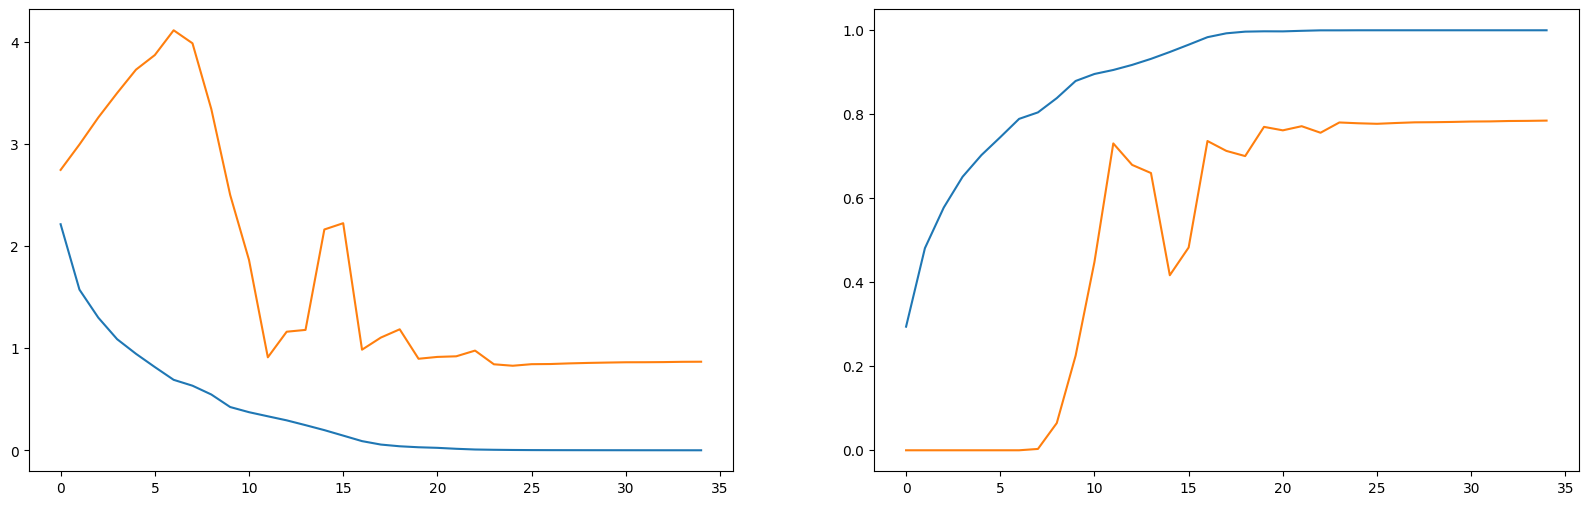

<Figure size 640x480 with 0 Axes>

In [ ]:
print('Tiempo promedio por época %.2f segundos' % epoch_timing.avg_epoch_time)
model.evaluate(train_ds)
model.evaluate(valid_ds)

# dibuja accuracy del progreso del entrenamiento
fig, axs = plt.subplots(1,2, figsize=(20,6))
plt.figure()
axs[0].plot(H.history["loss"], label="train_loss")
axs[0].plot(H.history["val_loss"], label="val_loss")

axs[1].plot(H.history["accuracy"], label="train_acc")
axs[1].plot(H.history["val_accuracy"], label="val_acc")

model.save('flowers_colab_Ejer_05_b.keras')

b) Modifique la arquitectura anterior agregando capas de BatchNormalization luego las capas de 
MaxPooling2D y entrene un nuevo modelo.  

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, LeakyReLU, Activation, BatchNormalization
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import unidecode
from tf_util import EpochTiming

# Constantes para arquitectura, generación de datos y entrenamiento/validación
IMG_SIZE = (96, 96)  # Tamaño de la imagen de entrada (se elimina el canal de la tupla)
N_CLASSES = 16       # Cantidad de clases a identificar
LOTES = 256          # Tamaño de lotes para entrenamiento y testeo
ALFA = 0.0005        # Tasa de aprendizaje
EPOCAS = 100         # Cantidad de épocas a entrenar como máximo
PACIENCIA = 10       # Parámetro para parada temprana
VAL_SPLIT = 0.2      # Porcentaje para validación

IMAGES_DIR = './FlowersX16/'  # Directorio con las imágenes organizadas en subcarpetas por clase

for root, dirs, files in os.walk(IMAGES_DIR):
    for name in dirs + files:
        new_name = unidecode.unidecode(name).replace(" ", "_")
        old_path = os.path.join(root, name)
        new_path = os.path.join(root, new_name)
        if old_path != new_path:
            os.rename(old_path, new_path)
            print(f"Renombrado: {old_path} → {new_path}")

# Función para crear datasets con aumento de datos
def create_dataset(directory, subset=None, shuffle=True):
    # Cargar dataset desde directorio
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=VAL_SPLIT,
        subset=subset,
        seed=123,
        image_size=IMG_SIZE,
        batch_size=LOTES,
        shuffle=shuffle
    )

    # Normalización
    def preprocess(image, label):
        return image/255.0, label

    # Aumento de datos (solo para entrenamiento)
    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)

        # Zoom y desplazamiento
        if tf.random.uniform(()) > 0.5:
            image = tf.image.central_crop(image, 0.85)
            image = tf.image.resize(image, IMG_SIZE)

        return image, label

    dataset = dataset.map(preprocess)
    if subset == 'training':
        dataset = dataset.map(augment)

    return dataset.cache().prefetch(tf.data.AUTOTUNE)

# Crear datasets
train_ds = create_dataset(IMAGES_DIR, subset='training', shuffle=True)
valid_ds = create_dataset(IMAGES_DIR, subset='validation', shuffle=False)

ACTIVATION = 'relu'
PADDING = 'same'

model = Sequential()

model.add(Input(shape=(*IMG_SIZE, 3)))

model.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())  # 🔹 Después del MaxPooling2D

model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())  # 🔹 Después del MaxPooling2D

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())  # 🔹 Después del MaxPooling2D

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())  # 🔹 Después del MaxPooling2D

model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())  # 🔹 Después del MaxPooling2D

model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation=ACTIVATION, padding=PADDING))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())  # 🔹 Después del MaxPooling2D

model.add(Flatten())
model.add(Dense(128, activation=ACTIVATION))
model.add(BatchNormalization())  # 🔹 También puede ir aquí
model.add(Activation(ACTIVATION))

model.add(Dense(N_CLASSES, activation='softmax'))

model.summary()

# obtiene la arquitectura para el modelo y lo compila
optimizer = optimizers.Adam(ALFA)
model.compile(optimizer,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# Callback para parada temprana
early_stop = EarlyStopping(monitor='val_loss',
                           patience=PACIENCIA,
                           restore_best_weights=True)

epoch_timing = EpochTiming()

H = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCAS,
    callbacks=[early_stop, epoch_timing])

Found 15740 files belonging to 16 classes.
Using 12592 files for training.
Found 15740 files belonging to 16 classes.
Using 3148 files for validation.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 96, 96, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 96, 96, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 24, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 3, 3, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,51

 Total params: 315,104 (1.20 MB)

 Trainable params: 313,984 (1.20 MB)

 Non-trainable params: 1,120 (4.38 KB)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 484ms/step - accuracy: 0.3547 - loss: 1.9817 - val_accuracy: 0.0000e+00 - val_loss: 2.8962
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 330ms/step - accuracy: 0.5352 - loss: 1.4126 - val_accuracy: 0.0000e+00 - val_loss: 3.2739
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 333ms/step - accuracy: 0.6194 - loss: 1.1723 - val_accuracy: 0.0000e+00 - val_loss: 3.6675
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 335ms/step - accuracy: 0.6936 - loss: 0.9688 - val_accuracy: 0.0000e+00 - val_loss: 4.0531
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 336ms/step - accuracy: 0.7556 - loss: 0.7993 - val_accuracy: 0.0000e+00 - val_loss: 4.2970
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 337ms/step - accuracy: 0.7812 - loss: 0.7228 - val_accuracy: 0.0105 - val_loss: 3.9101
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 341ms/step - accuracy: 0.7934 - loss: 0.6717 - val_accuracy: 0.0264 - val_loss: 3.8213
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 338ms/step - accuracy: 0.81

Tiempo promedio por época 17.30 segundos
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8062 - loss: 0.5938
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8256 - loss: 0.5960


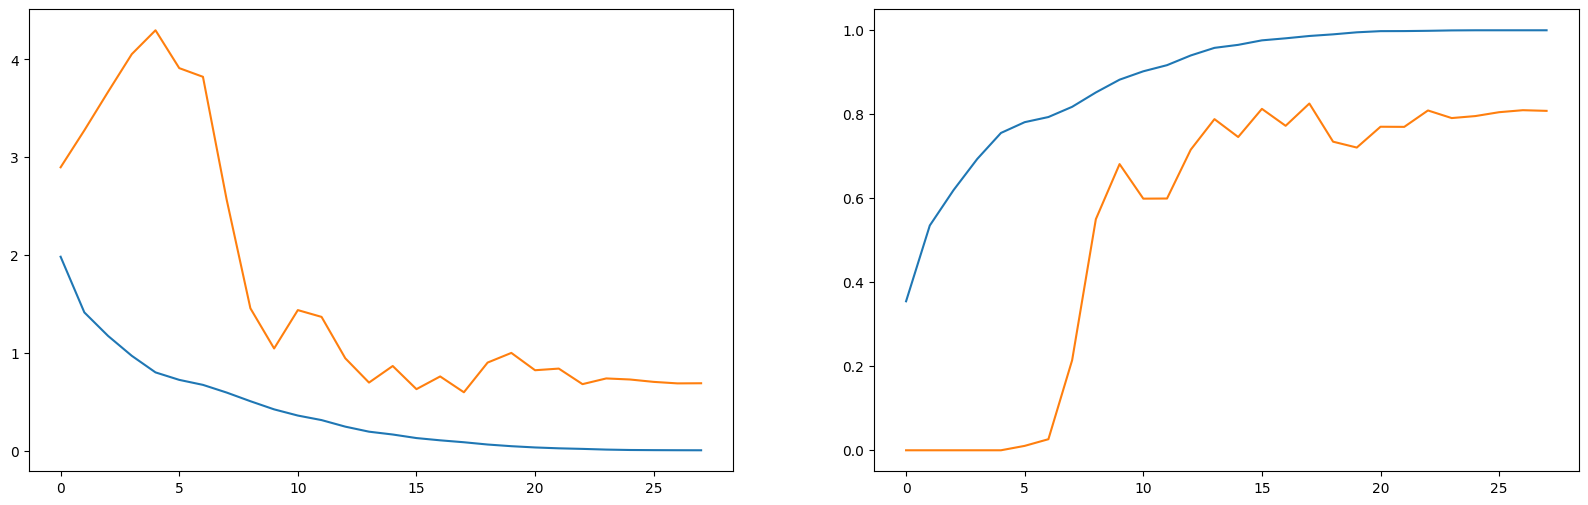

<Figure size 640x480 with 0 Axes>

In [ ]:
print('Tiempo promedio por época %.2f segundos' % epoch_timing.avg_epoch_time)
model.evaluate(train_ds)
model.evaluate(valid_ds)

# dibuja accuracy del progreso del entrenamiento
fig, axs = plt.subplots(1,2, figsize=(20,6))
plt.figure()
axs[0].plot(H.history["loss"], label="train_loss")
axs[0].plot(H.history["val_loss"], label="val_loss")

axs[1].plot(H.history["accuracy"], label="train_acc")
axs[1].plot(H.history["val_accuracy"], label="val_acc")

c) Compare las mediciones de los entrenamientos de los modelos de a) y b ¿Qué puede concluir? ¿Por 
qué? 

Modelo sin BatchNormalization (a):

La pérdida tarda más en bajar y es más inestable.

La precisión puede tener más fluctuaciones (saltos y bajadas).

Puede ocurrir sobreajuste más temprano si la red es profunda.

Modelo con BatchNormalization (b):

La pérdida tiende a bajar más rápido y de manera más estable.

La precisión sube más rápido y es más consistente.

El entrenamiento puede ser más rápido y confiable.

En general, la red aprende mejor y evita problemas de desvanecimiento/explosión del gradiente.

### Ejercicio 6
Re-implemente el ejercicio 5 utilizando las capas convolucionales del modelo Mobilenet V3 (clase 
MobileNetV3Small del paquete tensorflow.keras.applications) para extraer los patrones característicos y 
agregue una o más capas densas para entrenar una nueva red que permita reconocer los 16 tipos de flores 
del dataset “Flowers”. Recuerde que solo debe entrenar las capas densas.


Found 15740 files belonging to 16 classes.
Using 12592 files for training.
Found 15740 files belonging to 16 classes.
Using 3148 files for validation.


c:\Users\milen\Documents\Facultad\DeepLearning\.venv\Lib\site-packages\keras\src\applications\mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 3, 3, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         4,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,090,944 (4.16 MB)

 Trainable params: 151,824 (593.06 KB)

 Non-trainable params: 939,120 (3.58 MB)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.0635 - loss: 2.8019 - val_accuracy: 0.0000e+00 - val_loss: 2.7515
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.0740 - loss: 2.7659 - val_accuracy: 0.0000e+00 - val_loss: 2.7581
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.0834 - loss: 2.7615 - val_accuracy: 0.0000e+00 - val_loss: 2.7482
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.0833 - loss: 2.7577 - val_accuracy: 0.1471 - val_loss: 2.7046
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.0864 - loss: 2.7521 - val_accuracy: 0.2122 - val_loss: 2.7135
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.0882 - loss: 2.7471 - val_accuracy: 0.1395 - val_loss: 2.7037
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.0912 - loss: 2.7430 - val_accuracy: 0.0483 - val_loss: 2.7005
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.0939 - loss: 2.73

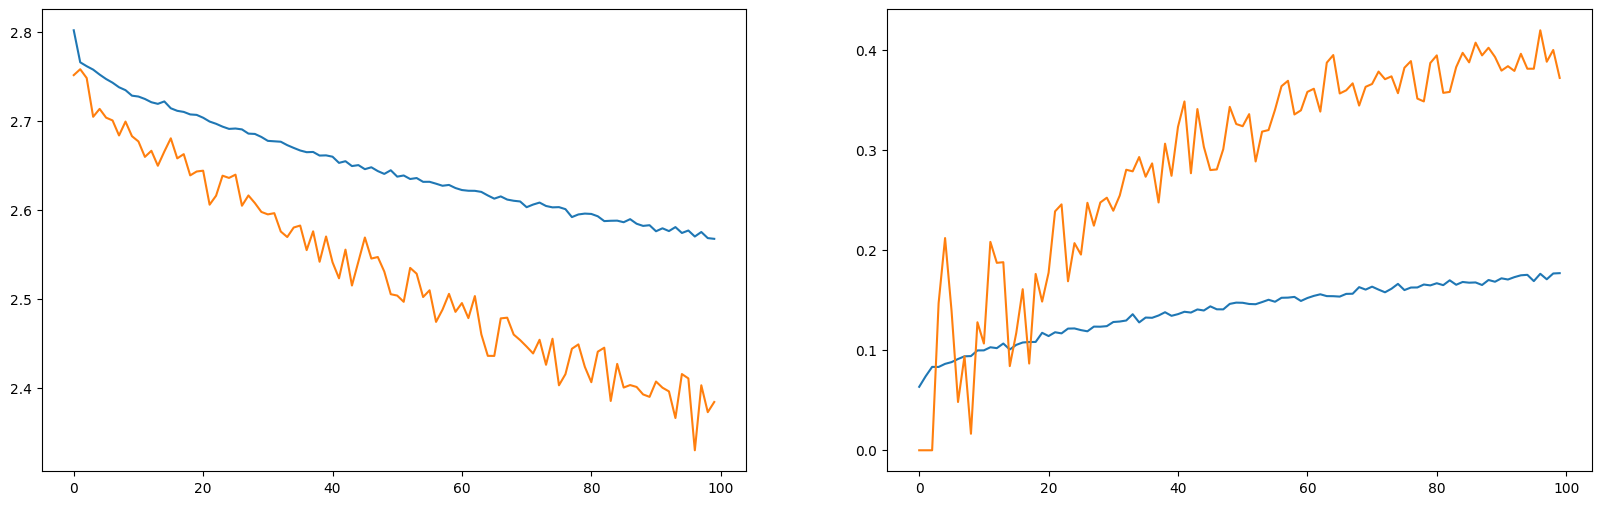

<Figure size 640x480 with 0 Axes>

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Activation, BatchNormalization, Lambda
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tf_util import EpochTiming
from matplotlib import pyplot as plt

# Constantes
IMG_SIZE = (96, 96)
N_CLASSES = 16
LOTES = 256
ALFA = 0.0005
EPOCAS = 100
PACIENCIA = 10
VAL_SPLIT = 0.2
IMAGES_DIR = './FlowersX16/'
# Función para crear datasets con aumento de datos
def create_dataset(directory, subset=None, shuffle=True):
    # Cargar dataset desde directorio
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        validation_split=VAL_SPLIT,
        subset=subset,
        seed=123,
        image_size=IMG_SIZE,
        batch_size=LOTES,
        shuffle=shuffle
    )

    # Normalización
    def preprocess(image, label):
        return image/255.0, label

    # Aumento de datos (solo para entrenamiento)
    def augment(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)

        # Zoom y desplazamiento
        if tf.random.uniform(()) > 0.5:
            image = tf.image.central_crop(image, 0.85)
            image = tf.image.resize(image, IMG_SIZE)

        return image, label

    dataset = dataset.map(preprocess)
    if subset == 'training':
        dataset = dataset.map(augment)

    return dataset.cache().prefetch(tf.data.AUTOTUNE)

train_ds = create_dataset(IMAGES_DIR, subset='training', shuffle=True)
valid_ds = create_dataset(IMAGES_DIR, subset='validation', shuffle=False)
# Si no, podés usar exactamente la misma función que tenías

# 1️⃣ Cargar MobileNetV3Small sin la parte de clasificación
base_model = MobileNetV3Small(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # congelamos las capas convolucionales

# 2️⃣ Construir el modelo usando MobileNetV3Small como extractor de características
model = Sequential([
    Input(shape=(*IMG_SIZE, 3)),
    Lambda(preprocess_input),  # preprocesamiento propio de MobileNetV3
    base_model,
    GlobalAveragePooling2D(),   # convierte la salida 2D en vector 1D
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(N_CLASSES, activation='softmax')
])

model.summary()

# 3️⃣ Compilar
optimizer = optimizers.Adam(ALFA)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4️⃣ Callbacks
early_stop = EarlyStopping(monitor='val_loss',
                           patience=PACIENCIA,
                           restore_best_weights=True)

epoch_timing = EpochTiming()

# 5️⃣ Entrenar
H = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=EPOCAS,
    callbacks=[early_stop, epoch_timing]
)
print('Tiempo promedio por época %.2f segundos' % epoch_timing.avg_epoch_time)
model.evaluate(train_ds)
model.evaluate(valid_ds)

# dibuja accuracy del progreso del entrenamiento
fig, axs = plt.subplots(1,2, figsize=(20,6))
plt.figure()
axs[0].plot(H.history["loss"], label="train_loss")
axs[0].plot(H.history["val_loss"], label="val_loss")

axs[1].plot(H.history["accuracy"], label="train_acc")
axs[1].plot(H.history["val_accuracy"], label="val_acc")

